In [82]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import json
from os import listdir
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

import statsmodels.api as sm


out_folder = 'arrow_output/'
in_folder = 'output/'
hist_folder = 'hist_output/'

# load the json files containing the results
with open(in_folder + 'results.json') as f:
    results = json.load(f)

# with open(in_folder + 'results_2.json') as f:
#     results_2 = json.load(f)

def get_idx(parameters):
    # Get index of the experiment associated with a particular parameter 
    # combination. Parameters are represented in an ordered numerical list
    parameter_idx = -1
    for i, experiment in enumerate(results):
        experiment_parameters = list(experiment.values())[:-1]
        if experiment_parameters == parameters:
            parameter_idx = i
            break
    
    return parameter_idx

def angles():
    # quantify the collective migration
    all_angles = {}
    all_stds = {}
    for i, experiment in enumerate(results):
        experiment_angles = {}
        experiment_stds = np.zeros(len(experiment['runs']))
        for j, run in enumerate(experiment['runs']):
            dxy = np.array(run['dxy'])
            # compute all the angles in radians
            new_angles = []
            for dx, dy in dxy:
                # tan of pi/2, 3pi/2 is undefined
                if dx == 0:
                    if dy > 0:
                        new_angles.append(np.pi/2)
                        continue
                    elif dy < 0:
                        new_angles.append(3*np.pi/2)
                        continue
                    else:
                        continue

                # want all angles from 0 to 2pi (where horizontal on the right
                # is zero on the unit circle), but arctan outputs them on
                # range of -pi/2, pi/2. We figure out how to convert this 
                # to our desired range depending on which of dx and dy are
                # negative. 
                angle = np.arctan(dy / dx)
                if not np.isnan(angle):
                    # 0 to pi/2
                    if dy > 0 and dx > 0:
                        new_angles.append(angle)
                    # pi/2 to 3pi/2    
                    elif (dy < 0 and dx < 0) or (dy>0 and dx < 0):
                        new_angles.append(np.pi + angle)
                    # 3pi/2 to 2pi
                    else:
                        new_angles.append(2*np.pi + angle)

            # compute the circular mean, to shift the distribution to 0
            circmean = scipy.stats.circmean(new_angles)
            new_angles = [angle-circmean for angle in new_angles]

            experiment_angles[j] = new_angles
            experiment_stds[j] = scipy.stats.circstd(new_angles)

        all_angles[i] = experiment_angles 
        all_stds[i] = experiment_stds

    return all_angles, all_stds 

def plot_data(parameters, iv_idx, datapoints):
    # plot the processed datapoints of all trials, for experiments specified in
    # the parameters array. The array is of shape (n_experiments, n_parameters),
    # where n_experiments depends on the independent variable being tested. 
    # iv_idx is the column index of parameters where the independent variable
    # parameter is represented. 

    # get the indices of the correct experiments
    experiment_indices = np.zeros(parameters.shape[0])
    for i, pars in enumerate(parameters):
        experiment_indices[i] = get_idx(pars.tolist())
    
    # get corresponding data
    experiment_data = []
    for idx in experiment_indices:
        experiment_data += list(datapoints[idx])
    
    # create x values for plotting
    n_trials = len(experiment_data)//len(experiment_indices)
    x = np.ones(len(experiment_data))
    for i, iv in enumerate(parameters[:,iv_idx]):
        x[i*n_trials:i*n_trials+n_trials] *= iv

    X2 = sm.add_constant(x)
    est = sm.OLS(experiment_data, X2)
    est2 = est.fit()
    print(est2.summary())
    
    plt.scatter(x, experiment_data)
    
    # Line of best fit 
    a, b = np.polyfit(x, experiment_data, 1)
    return a, b, x

def plot_polar(angles, std):
    width = 1

    # plt the results polar
    ax = plt.subplot(projection='polar')

    plt.hist(angles, bins=10, density=True, label='Samples')
    plt.vlines([-width * std, width * std], 0, 1, 
               linestyles='--', color='red', 
               label=f'$[-{width}\sigma, {width}\sigma]$ interval')

    plt.xlabel('Direction (degrees, shifted to mean 0)')

    angle = np.deg2rad(67.5)
    plt.legend(loc='upper left', bbox_to_anchor=(.55 + np.cos(angle)/2, .63 + np.sin(angle)/2))
    

In [55]:
all_angles, all_stds = angles()

## Plotting raw data in polar coordinates, for two of the trials


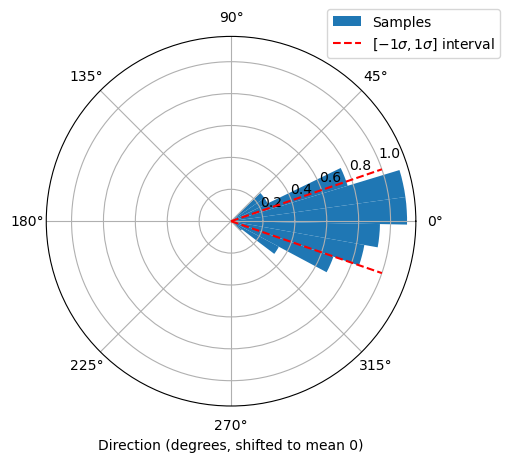

In [83]:
# Experiment 1, grid size of 0
grid_size_parameters = [0, 340, 20, 100, 10, 180]
idx_1 = get_idx(grid_size_parameters)
plot_polar(all_angles[idx_1][0], all_stds[idx_1][0])
plt.savefig(hist_folder + 'g0.png', bbox_inches='tight', dpi=300)


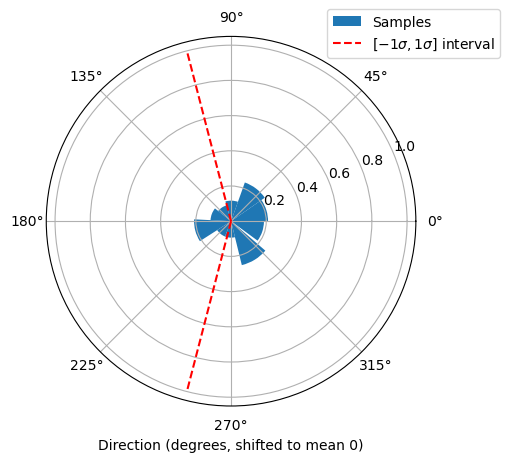

In [84]:
# Experiment 1, grid size of 6
grid_size_parameters = [6, 340, 20, 100, 10, 180]
idx_2 = get_idx(grid_size_parameters)
plot_polar(all_angles[idx_2][4], all_stds[idx_2][4])
plt.savefig(hist_folder + 'g6.png', bbox_inches='tight', dpi=300)


## Global level collective migration quantification

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     359.2
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           7.66e-29
Time:                        23:13:28   Log-Likelihood:                -2.3079
No. Observations:                  70   AIC:                             8.616
Df Residuals:                      68   BIC:                             13.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1988      0.055      3.636      0.0

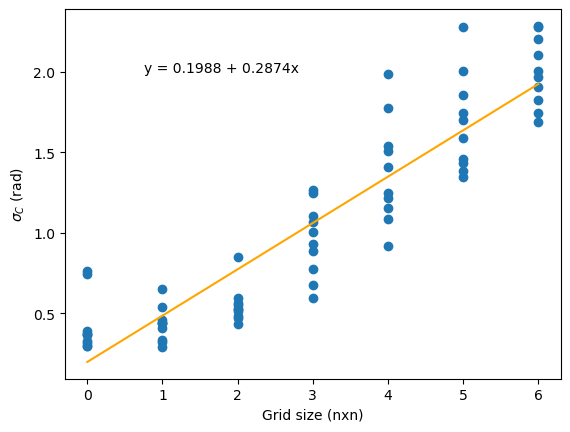

In [57]:
grid_size_parameters = np.array([[0, 340, 20, 100, 10, 180],
                                 [1, 340, 20, 100, 10, 180],
                                 [2, 340, 20, 100, 10, 180],
                                 [3, 340, 20, 100, 10, 180],
                                 [4, 340, 20, 100, 10, 180],
                                 [5, 340, 20, 100, 10, 180],
                                 [6, 340, 20, 100, 10, 180]])

a, b, x = plot_data(grid_size_parameters, 0, all_stds)
plt.plot(x, a*x + b, color='orange')
plt.text(0.75, 2, 'y = ' + '{:.4f}'.format(b) + ' + {:.4f}'.format(a) + 'x', size=10)

plt.xlabel("Grid size (nxn)")
plt.ylabel("$\sigma_C\  (\mathrm{rad})$")
plt.savefig(f'graphs/grid_size_global.png', bbox_inches="tight", dpi=300)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     5.334
Date:                Mon, 04 Mar 2024   Prob (F-statistic):             0.0285
Time:                        01:43:02   Log-Likelihood:                 11.513
No. Observations:                  30   AIC:                            -19.03
Df Residuals:                      28   BIC:                            -16.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9162      0.042     21.580      0.0

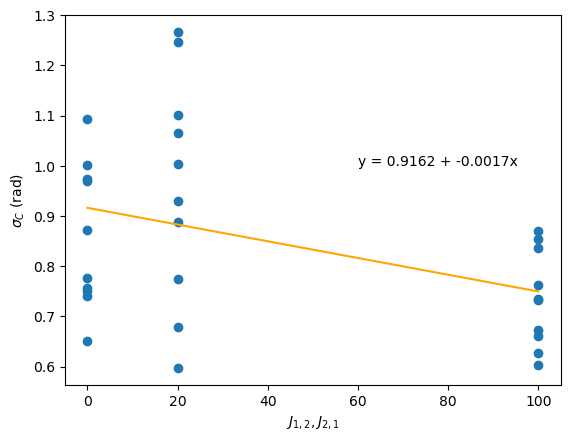

In [85]:
adhesion_parameters = np.array([[3, 340, 0, 100, 10, 180],
                                [3, 340, 20, 100, 10, 180],
                                [3, 340, 100, 100, 10, 180]])

a, b, x = plot_data(adhesion_parameters, 2, all_stds)
plt.plot(x, a*x + b, color='orange')
plt.text(60, 1, 'y = ' + '{:.4f}'.format(b) + ' + {:.4f}'.format(a) + 'x', size=10)

plt.xlabel("$J_{1,2}, J_{2,1}$")
plt.ylabel("$\sigma_C\  (\mathrm{rad})$")
plt.savefig(f'graphs/J_global.png', bbox_inches="tight", dpi=300)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     33.05
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           3.61e-06
Time:                        23:13:42   Log-Likelihood:                -6.3214
No. Observations:                  30   AIC:                             16.64
Df Residuals:                      28   BIC:                             19.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4696      0.435      7.982      0.0

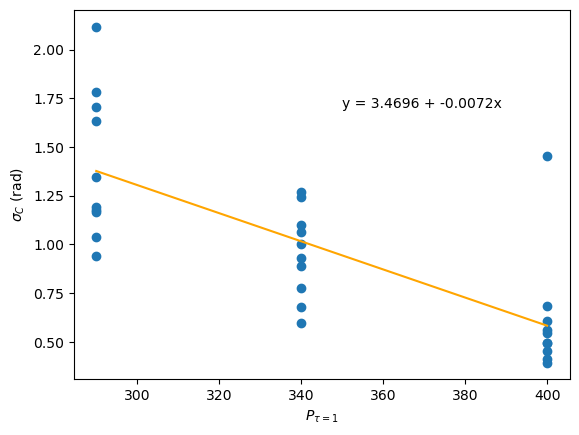

In [59]:
perimeter_parameters = np.array([[3, 290, 20, 100, 10, 180],
                                [3, 340, 20, 100, 10, 180],
                                [3, 400, 20, 100, 10, 180]])

a, b, x = plot_data(perimeter_parameters, 1, all_stds)
plt.plot(x, a*x + b, color='orange')
plt.text(350, 1.7, 'y = ' + '{:.4f}'.format(b) + ' + {:.4f}'.format(a) + 'x', size=10)

plt.xlabel("$P_{\\tau = 1}$")
plt.ylabel("$\sigma_C\  (\mathrm{rad})$")
plt.savefig(f'graphs/tau_global.png', bbox_inches="tight", dpi=300)

## Local level collective migration quantification

In [61]:
def local_collective(k):
    local_collectiveness = {}
    for j, experiment in enumerate(results):

        local_collectiveness_experiment = np.zeros(len(experiment['runs']))

        for i, run in enumerate(experiment['runs']):

            cell_positions = run['xy']
            distances = euclidean_distances(np.array(cell_positions))
            # find the k cells closest to each cell in euclidean space. Each
            # row represents one cell, where the columns are the k cells closest
            # to the cell corresponding to the index of the row
            k_nearest_idx = np.argsort(distances, axis=1)[:,1:k+1]
            # compute the cosine similarity between all pairs of 
            # displacement vectors
            cell_displacements = np.array(run['dxy'])            
            all_similarities = cosine_similarity(cell_displacements)

            # find the similarities between each cell and its k nearest neighbors
            k_similarities = all_similarities[
                np.arange(len(k_nearest_idx))[:, None], k_nearest_idx]
            # average across the k neighbors, then across cells
            local_collectiveness_experiment[i] = \
                np.mean(np.mean(k_similarities, axis=1), axis=0)
            
        local_collectiveness[j] = local_collectiveness_experiment
    
    return local_collectiveness

In [62]:
lcis = local_collective(5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     741.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           2.70e-38
Time:                        23:14:03   Log-Likelihood:                 66.736
No. Observations:                  70   AIC:                            -129.5
Df Residuals:                      68   BIC:                            -125.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9961      0.020     48.856      0.0

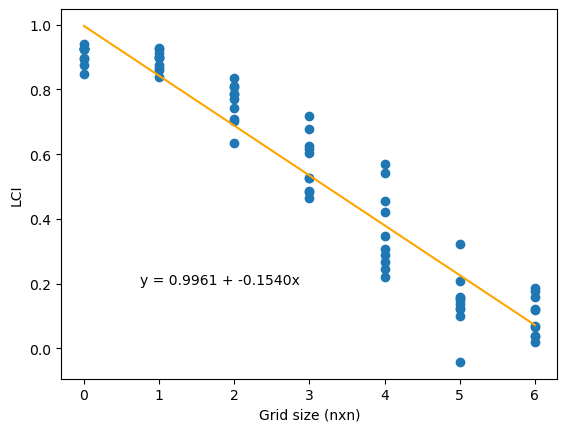

In [64]:
a, b, x = plot_data(grid_size_parameters, 0, lcis)
plt.plot(x, a*x + b, color='orange')
plt.text(0.75, .2, 'y = ' + '{:.4f}'.format(b) + ' + {:.4f}'.format(a) + 'x', size=10)

plt.xlabel("Grid size (nxn)")
plt.ylabel("LCI")
plt.savefig(f'graphs/grid_size_local.png', bbox_inches="tight", dpi=300)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     6.773
Date:                Sun, 03 Mar 2024   Prob (F-statistic):             0.0146
Time:                        23:14:08   Log-Likelihood:                 29.847
No. Observations:                  30   AIC:                            -55.69
Df Residuals:                      28   BIC:                            -52.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5736      0.023     24.893      0.0

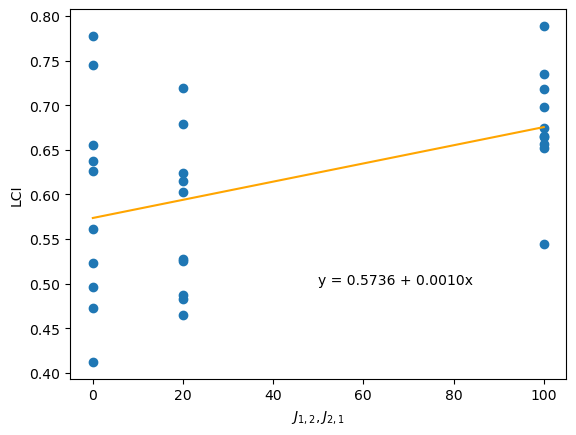

In [65]:
a, b, x = plot_data(adhesion_parameters, 2, lcis)
plt.plot(x, a*x + b, color='orange')
plt.text(50, 0.5, 'y = ' + '{:.4f}'.format(b) + ' + {:.4f}'.format(a) + 'x', size=10)

plt.xlabel("$J_{1,2}, J_{2,1}$")
plt.ylabel("LCI")
plt.savefig(f'graphs/J_local.png', bbox_inches="tight", dpi=300)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     74.84
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           2.13e-09
Time:                        23:14:11   Log-Likelihood:                 26.939
No. Observations:                  30   AIC:                            -49.88
Df Residuals:                      28   BIC:                            -47.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6591      0.143     -4.594      0.0

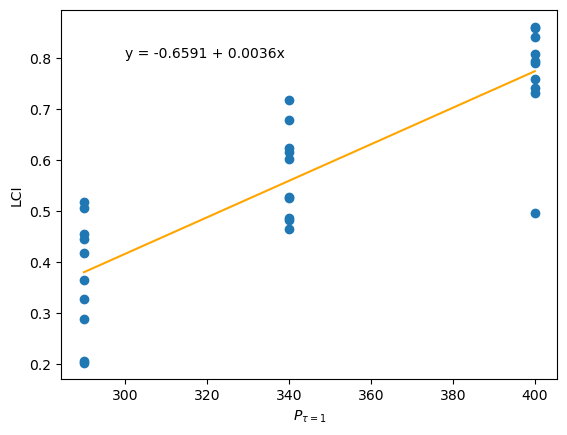

In [66]:
a, b, x = plot_data(perimeter_parameters, 1, lcis)
plt.plot(x, a*x + b, color='orange')
plt.text(300, 0.8, 'y = ' + '{:.4f}'.format(b) + ' + {:.4f}'.format(a) + 'x', size=10)

plt.xlabel("$P_{\\tau = 1}$")
plt.ylabel("LCI")
plt.savefig(f'graphs/tau_local.png', bbox_inches="tight", dpi=300)